# Machine Learning and Statistics for Physicists

## Homework 9

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import torch.nn
import torch.optim
import torch.utils.data

In this homework, you will extend some of the studies described in the [Best Practices](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/NNTricks.ipynb) notebook. We start by recreating the training and test datasets:

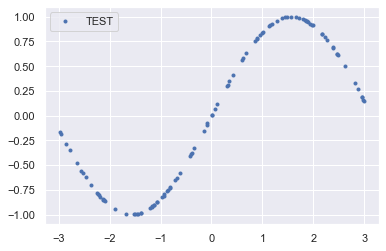

In [3]:
torch.manual_seed(123)
x_train = 6 * torch.rand((1000, 1)) - 3
y_train = torch.sin(x_train)
x_test = 6 * torch.rand((100, 1)) - 3
y_test = torch.sin(x_test)
plt.plot(x_test.numpy(), y_test.numpy(), '.', label='TEST')
plt.legend();

Wrap the tensors into Dataset objects to simplify passing them around:

In [4]:
xy_train = torch.utils.data.TensorDataset(x_train, y_train)
xy_test = torch.utils.data.TensorDataset(x_test, y_test)

Create (and save) the baseline model to use:

In [5]:
torch.manual_seed(123)
baseline = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1),
)
torch.save(baseline.state_dict(), 'baseline.pth')

### Problem 1

Implement the function below to build a train and test loop using hyperparameters specified as function arguments. Your code should produce a single scatter plot showing the TRAIN and TEST loss curves, similar to the ones we produced earlier.

In [8]:
def learn(train_data, test_data, model, loss_fn=torch.nn.MSELoss(), n_epochs=200,
          batch_size=200, learning_rate=0.1, momentum=0.9):
    """Perform a train and test loop with specified hyperparameters.
    
    Uses SGD optimization and produces a scatter plot of TRAIN and TEST
    loss versus epoch on a log-linear scale.
    
    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Container for the training input and target tensors to use.
    test_data : torch.utils.data.Dataset
        Container for the test input and target tensors to use.
    model : torch.nn.Module
        Neural network model of the data whose parameters will be learned.
    loss_fn : callable
        Function of (y_out, y_tgt) that calculates the scalar loss to use.
        Must support backwards() method.
    n_epochs : int
        Number of epochs of training to perform.
    batch_size : int
        Size of each (randomly shuffled) minibatch to use.
    learning_rate : float
        Learning rate to use for the SGD optimizer.
    momentum : float
        Momentum to use for the SGD optimizer.
        
    Returns
    -------
    tuple
        Tuple (train, test) of arrays of loss values after each epoch for
        the TRAIN and TEST samples, respectively. Both lists should have
        length equal to n_epochs.    
    """
    losses_train, losses_test = [], []
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    x_test, y_test = test_data.tensors
    # YOUR CODE HERE
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(n_epochs):
        
        model.train()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

        losses_train.append(loss.data)

        model.eval()
        y_pred = model(x_test)
        losses_test.append(loss_fn(y_pred, y_test).data)
    
    
    
    plt.plot(losses_train, '.', label='TRAIN')
    plt.plot(losses_test, '.', label='TEST')
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log');
    return losses_train, losses_test

Test your code with the default hyperparameters using:

AssertionError: 

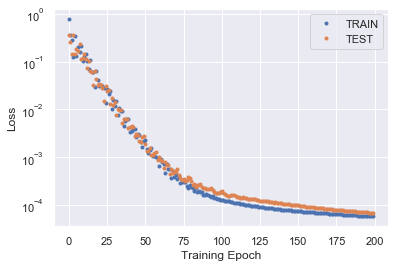

In [9]:
# A correct solution should pass these tests.
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
train, test = learn(xy_train, xy_test, baseline)
assert train[0] > 0.1 and test[0] > 0.1
assert train[15] < 1e-3 and test[15] < 1e-3
assert train[-1] < 1e-4 and test[-1] < 1e-4

Run the cell below to establish the same initial state (seed and model parameters) and repeat this learning loop with the optimizer momentum set to zero, to show its effect on the loss curves: large synchronized oscillations in both the TRAIN and TEST data.

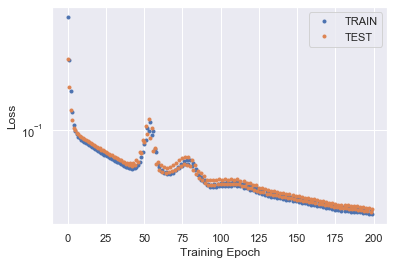

In [10]:
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
learn(xy_train, xy_test, baseline, momentum=0);

### Problem 2

In this problem you will explore some of the "hyperdecisions" involved in selecting a network architecture, re-using your `learn()` function from the previous problem.

First, vary the number of hidden nodes on the second layer from 25 to 10 (using the default `learn` hyperparameters).

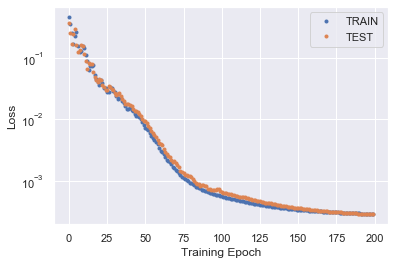

In [11]:
torch.manual_seed(123)
# YOUR CODE HERE

model2 = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
torch.save(model2.state_dict(), 'model2.pth')

model2.load_state_dict(torch.load('model2.pth'))
train, test = learn(xy_train, xy_test, model2)

Next, change both activations from `ReLU` to `Tanh` (going back to 25 nodes on the second layer):

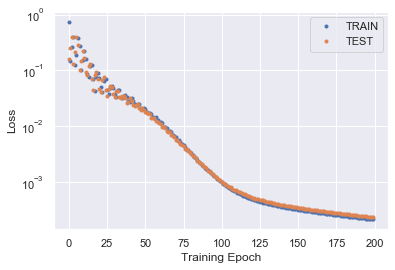

In [12]:
torch.manual_seed(123)
# YOUR CODE HERE

model3 = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 25),
    torch.nn.Tanh(),
    torch.nn.Linear(25, 1),
)
torch.save(model3.state_dict(), 'model3.pth')

model3.load_state_dict(torch.load('model3.pth'))
train, test = learn(xy_train, xy_test, model3)

Finally, go back to `ReLU` for the hidden activations, but add a `Tanh` activation on the output node, since it enforces an output in the range [-1,+1] which matches our target range:

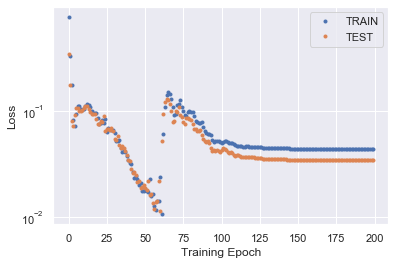

In [14]:
torch.manual_seed(123)
# YOUR CODE HERE

model4 = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1),
    torch.nn.Tanh()
)
torch.save(model4.state_dict(), 'model4.pth')

model4.load_state_dict(torch.load('model4.pth'))
train, test = learn(xy_train, xy_test, model4)

### Problem 3

In this problem, you will explore the effects of varying the learning rate according to some schedule, using the [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) utilities.

Implement the function below to build a train and test loop that uses a specified learning rate schedule. You should be able to copy most of your code from your earlier `learn` function. Note that we need to create an optimizer before we can create a scheduler, so this changes the function's API.

In [15]:
def learn_with_schedule(train_data, test_data, model, scheduler,
                        loss_fn=torch.nn.MSELoss(), n_epochs=200, batch_size=200):
    """Perform a train and test loop with specified hyperparameters.
    
    Uses SGD optimization with a learning rate schedule and produces a
    scatter plot of TRAIN and TEST loss versus epoch on a log-linear scale.
    
    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Container for the training input and target tensors to use.
    test_data : torch.utils.data.Dataset
        Container for the test input and target tensors to use.
    model : torch.nn.Module
        Neural network model of the data whose parameters will be learned.
    scheduler : object
        Object with a step() method to update the learning rate schedule
        before each training epoch.
    loss_fn : callable
        Function of (y_out, y_tgt) that calculates the scalar loss to use.
        Must support backwards() method.
    n_epochs : int
        Number of epochs of training to perform.
    batch_size : int
        Size of each (randomly shuffled) minibatch to use.
    
    Returns
    -------
    tuple
        Tuple (train, test) of arrays of loss values after each epoch for
        the TRAIN and TEST samples, respectively. Both lists should have
        length equal to n_epochs.    
    """
    losses_train, losses_test = [], []
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    x_test, y_test = test_data.tensors
    optimizer = scheduler.optimizer
    # YOUR CODE HERE
    
    for epoch in range(n_epochs):
        
        model.train()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

        losses_train.append(loss.data)

        model.eval()
        y_pred = model(x_test)
        losses_test.append(loss_fn(y_pred, y_test).data)
        
        scheduler.step()
    

    plt.plot(losses_train, '.', label='TRAIN')
    plt.plot(losses_test, '.', label='TEST')
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log');
    return losses_train, losses_test

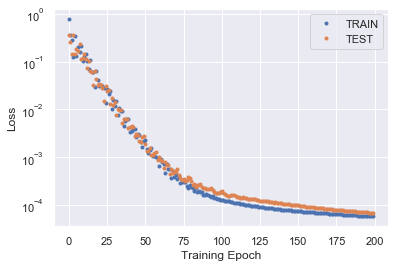

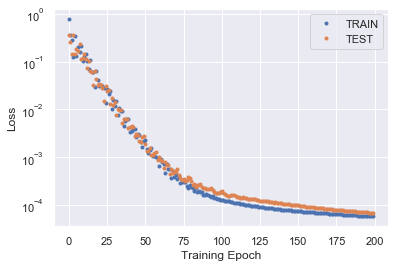

In [16]:
# A correct solution should pass these tests.
optimizer = torch.optim.SGD(baseline.parameters(), lr=0.1, momentum=0.9)

# A constant scheduler should give identical results to the initial learn function.
ConstantLR = lambda epoch: 1.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, ConstantLR)

torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
train1, test1 = learn_with_schedule(xy_train, xy_test, baseline, scheduler)
plt.show()

torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
train2, test2 = learn(xy_train, xy_test, baseline, learning_rate=0.1, momentum=0.9)
plt.show()

assert np.all(train1 == train2) and np.all(test1 == test2)

Test a suite of schedules on the same problem using your code:

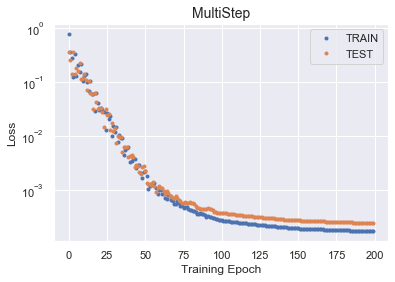

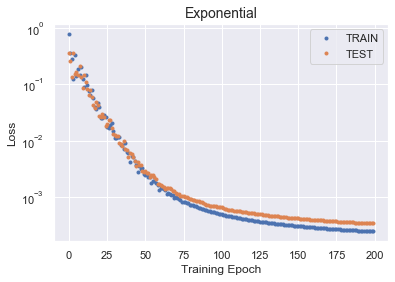

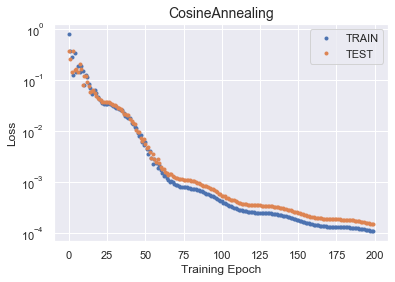

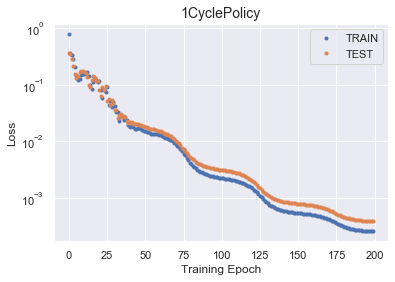

In [17]:
optimizer = torch.optim.SGD(baseline.parameters(), lr=0.1, momentum=0.9)
torch.save(optimizer.state_dict(), 'optimizer.pth')

def OneCyclePolicy(epoch, period=50, frac=0.1):
    phase = (epoch % period) / period
    gamma = frac ** (-2 / period)
    #print(phase, gamma)
    if phase < 0.5:
        return frac * gamma ** (period * phase)
    else:
        return frac * gamma ** (period * (1 - phase))

schedulers = {
    'MultiStep': torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150], gamma=0.5),
    'Exponential': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.01),
    '1CyclePolicy': torch.optim.lr_scheduler.LambdaLR(optimizer, OneCyclePolicy),
}

for name, scheduler in schedulers.items():
    torch.manual_seed(123)
    baseline.load_state_dict(torch.load('baseline.pth'))
    optimizer.load_state_dict(torch.load('optimizer.pth'))
    learn_with_schedule(xy_train, xy_test, baseline, scheduler)
    plt.title(name, fontsize=14)
    plt.show()